# Zillow Clustering Project
<!-- Describe your project in brief -->
The Zestimate is a powerful tool used by zillow to predict the final sale price of realestate. My goal for this project is to identify whats driving error between the Zestimate and the final sale prices. To accomplish this goal I will be utilizing clustering and regression models. I will present my findings via a notebook walkthrough to my datascience team.   


# Executive Summary
<!-- Add a demo for your project -->

Goal of this project was to find what was driving log error.

I failed to beat the baseline model RMSE of .15

My best model was an OLS model with an RMSE of .161 on unseen data

The clusters I created where ineffective given more time I'd like to do more engineering.

In [1]:
import pandas as pd
import numpy as np
import wrangle as w
import explore as e
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='white')
sns.set_palette("colorblind")
import sklearn.preprocessing
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

import sklearn.preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression

from scipy import stats

import warnings
warnings.filterwarnings("ignore")

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression, RFE
import statsmodels.api as sm
from sklearn.metrics import explained_variance_score

### Acquire & Prep

In [2]:
# Bring in the data cleaned and wrangled
train, validate, test = w.prep_zillow()

In [3]:
# Verify the shapes
train.shape, validate.shape, test.shape

((30163, 21), (12927, 21), (10773, 21))

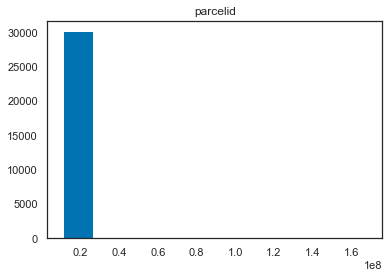

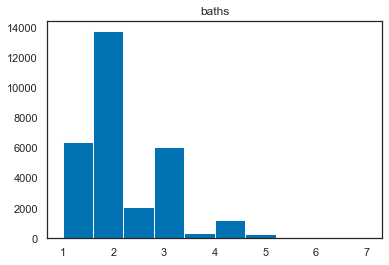

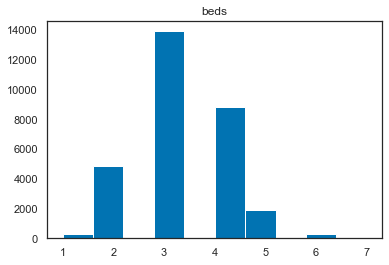

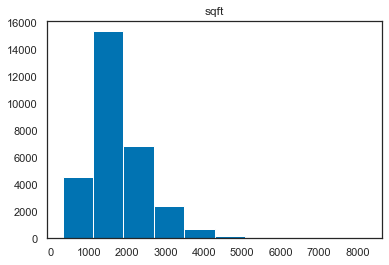

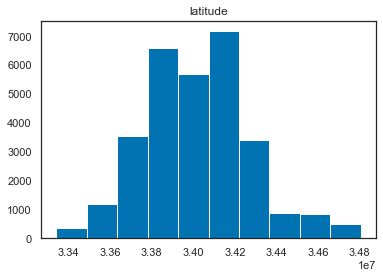

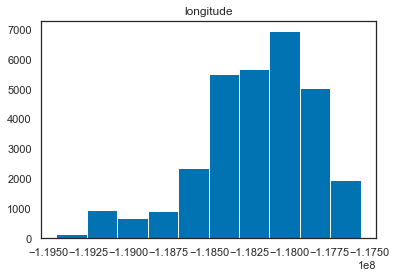

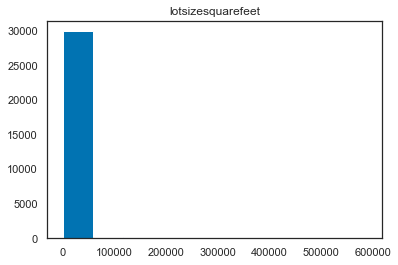

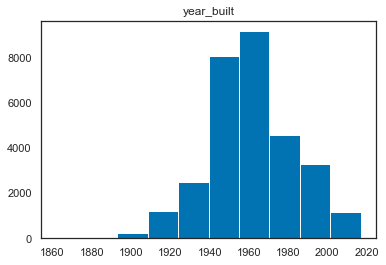

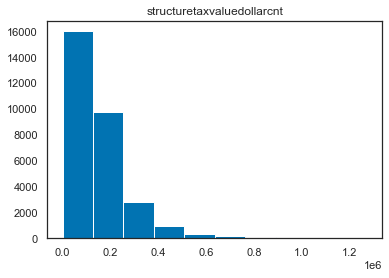

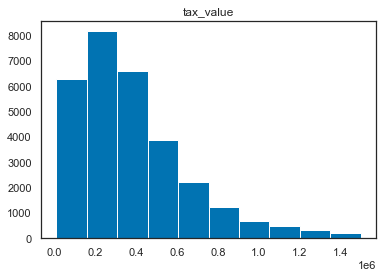

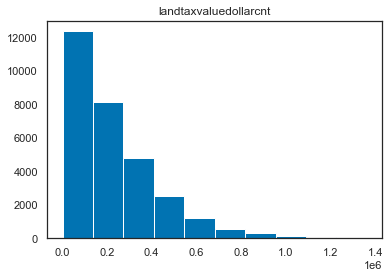

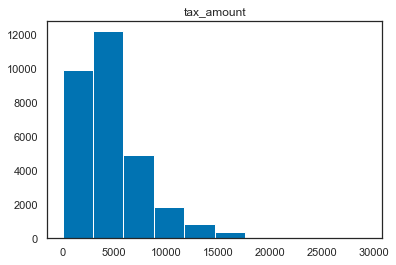

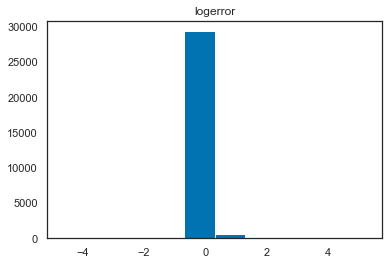

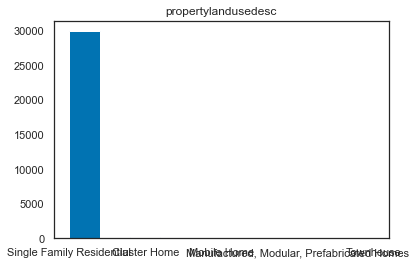

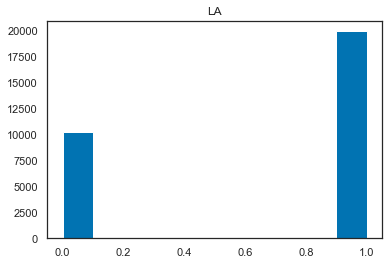

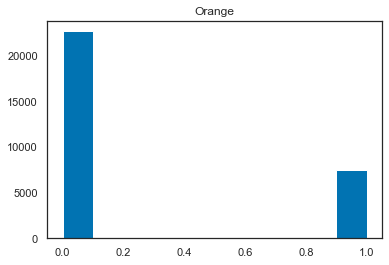

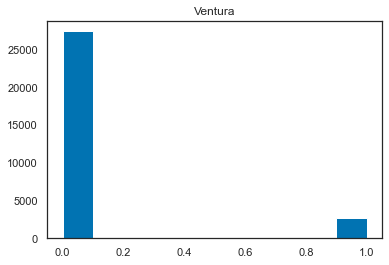

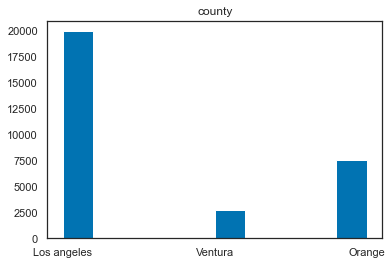

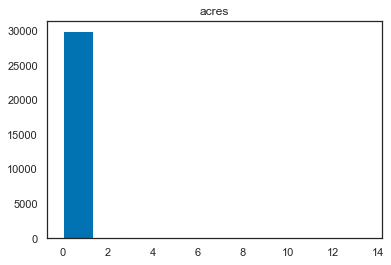

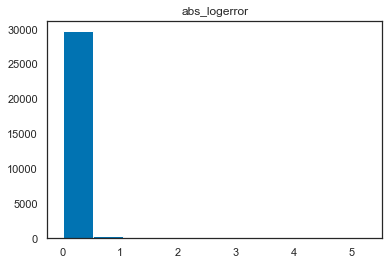

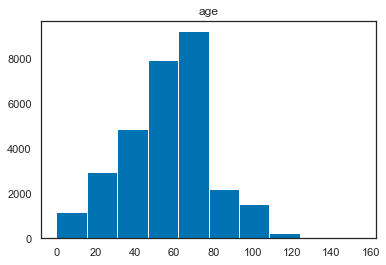

In [4]:
# View the distrubutions
e.distros(train)

### Explore

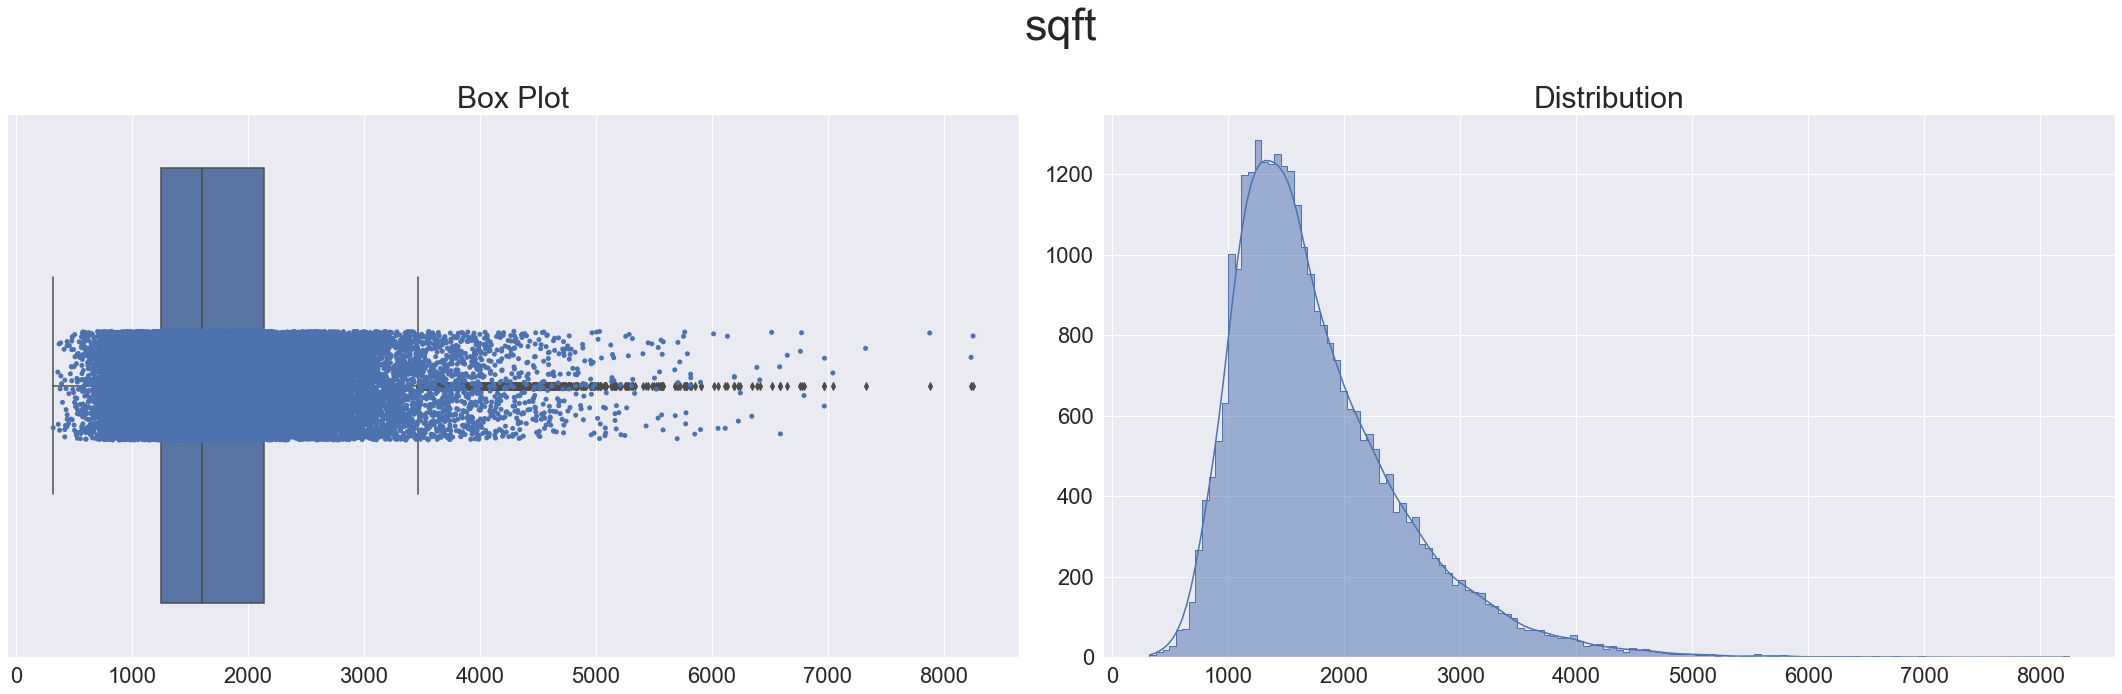

Summary Statistics for sqft
count    30163.000000
mean      1778.226171
std        751.052572
min        320.000000
25%       1249.500000
50%       1599.000000
75%       2136.000000
max       8251.000000
Name: sqft, dtype: float64


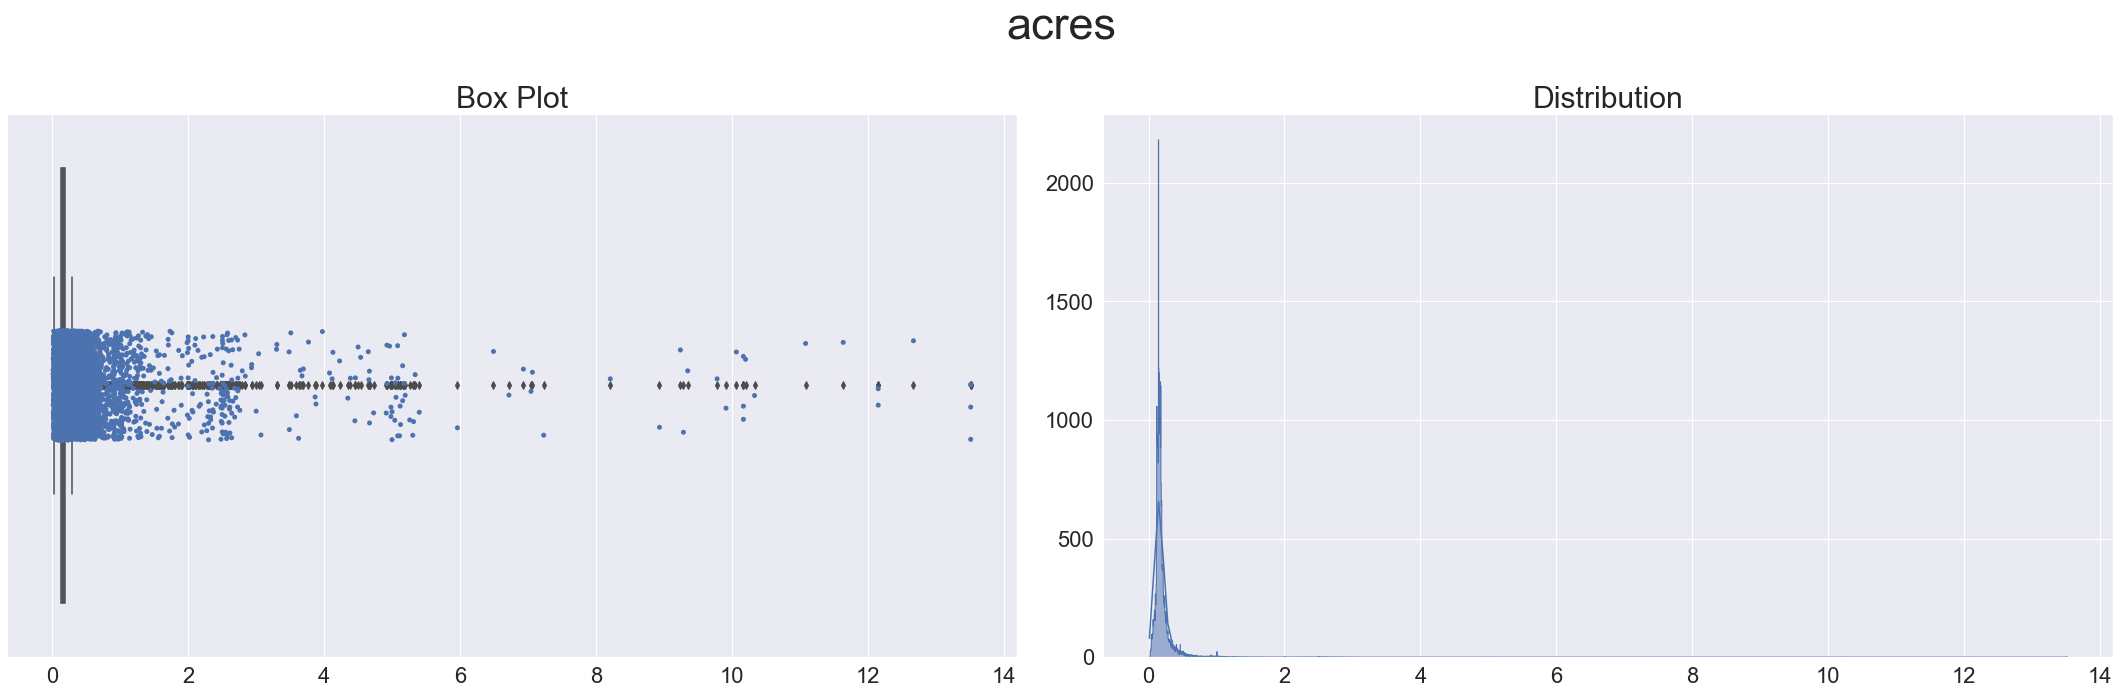

Summary Statistics for acres
count    30163.000000
mean         0.214296
std          0.415074
min          0.011478
25%          0.128972
50%          0.154959
75%          0.193916
max         13.515565
Name: acres, dtype: float64


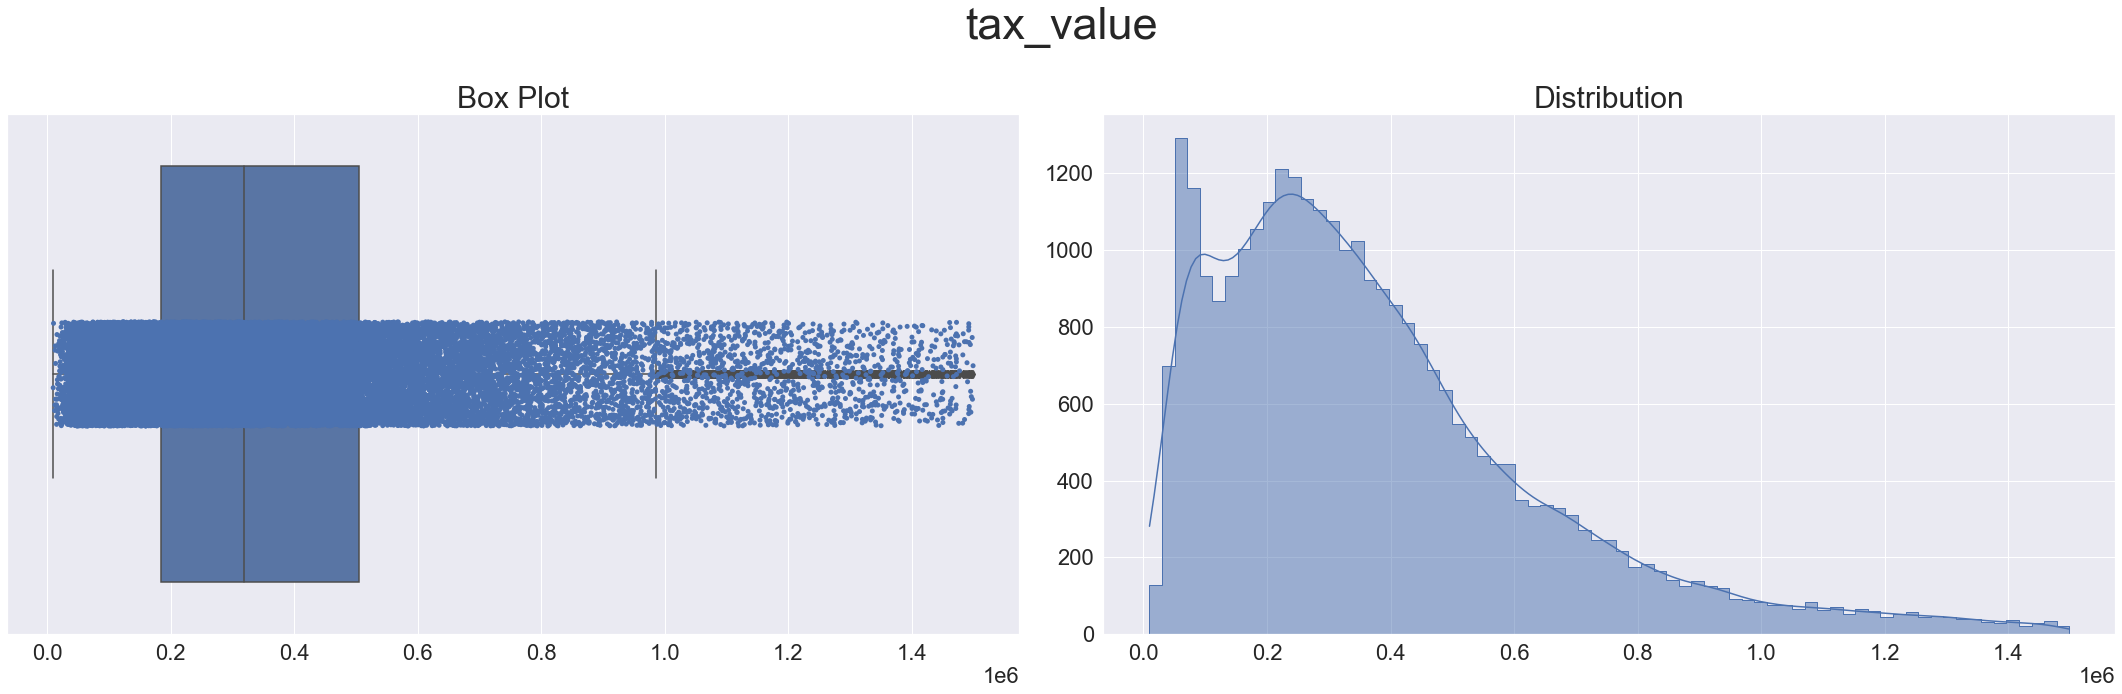

Summary Statistics for tax_value
count    3.016300e+04
mean     3.809798e+05
std      2.743848e+05
min      9.762000e+03
25%      1.835675e+05
50%      3.192270e+05
75%      5.045015e+05
max      1.498929e+06
Name: tax_value, dtype: float64


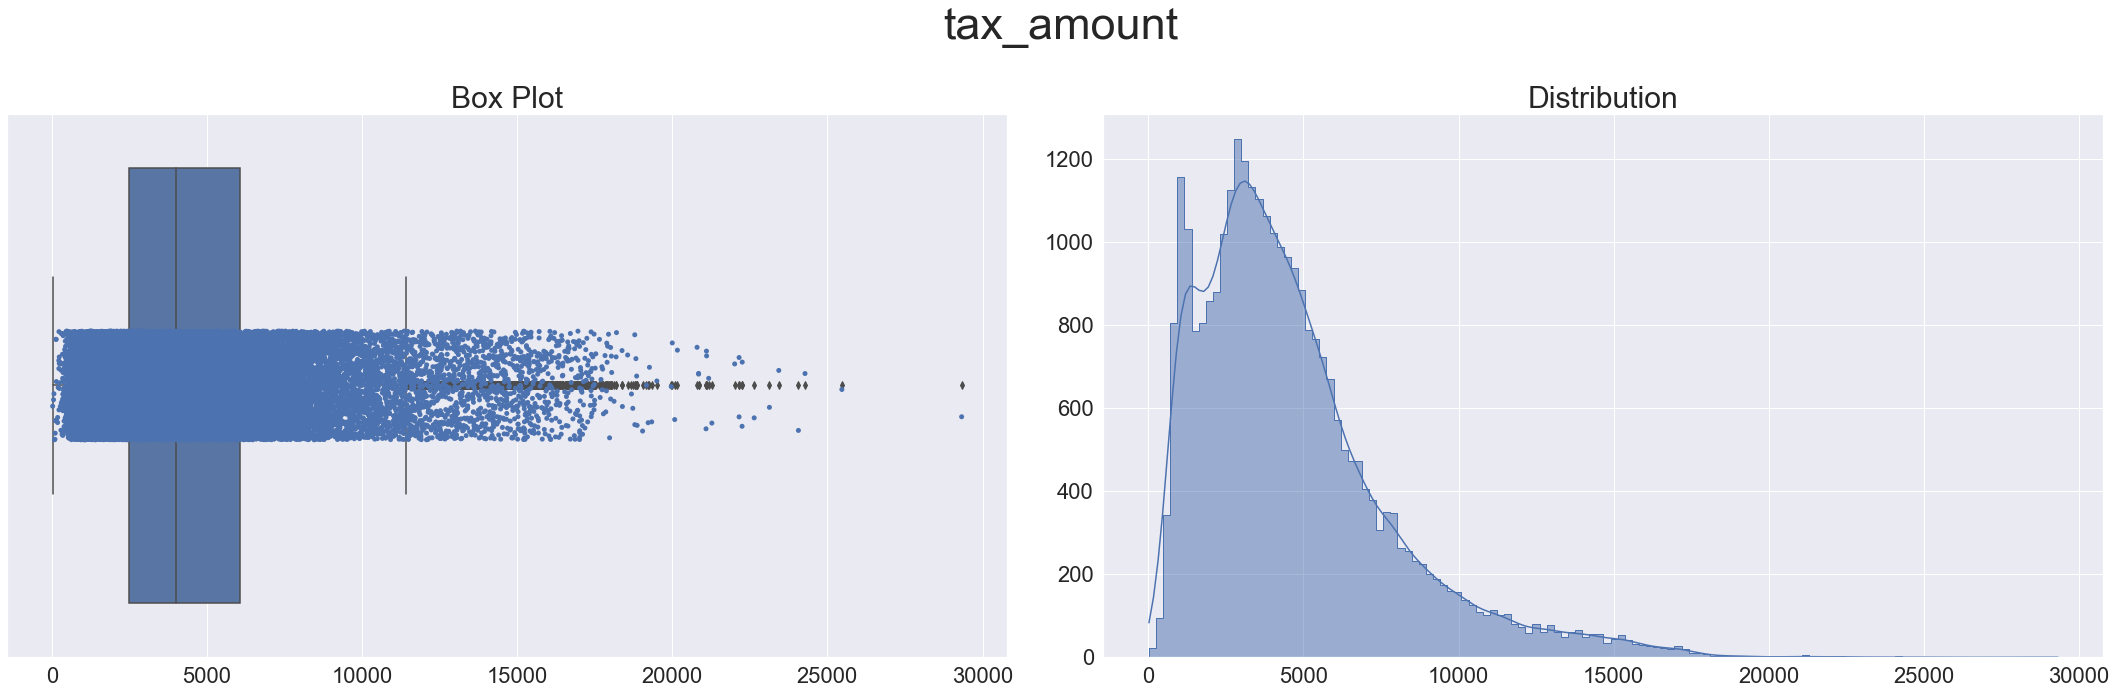

Summary Statistics for tax_amount
count    30163.000000
mean      4695.048434
std       3181.064090
min         20.240000
25%       2479.910000
50%       4003.590000
75%       6048.875000
max      29324.650000
Name: tax_amount, dtype: float64


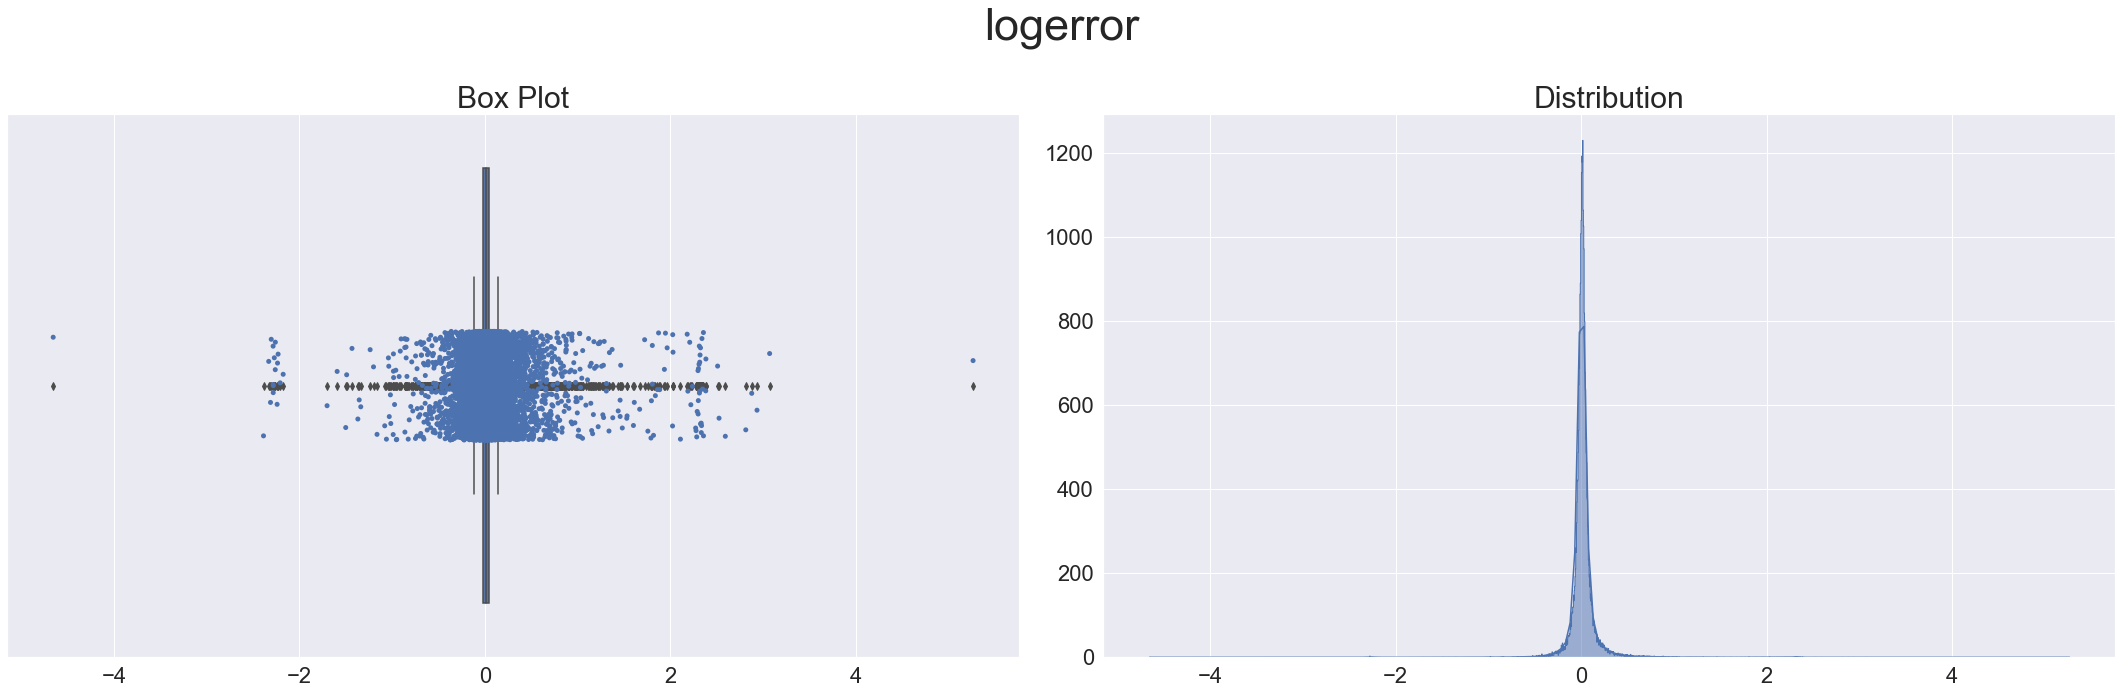

Summary Statistics for logerror
count    30163.000000
mean         0.016181
std          0.174008
min         -4.655420
25%         -0.024767
50%          0.006706
75%          0.039372
max          5.262999
Name: logerror, dtype: float64


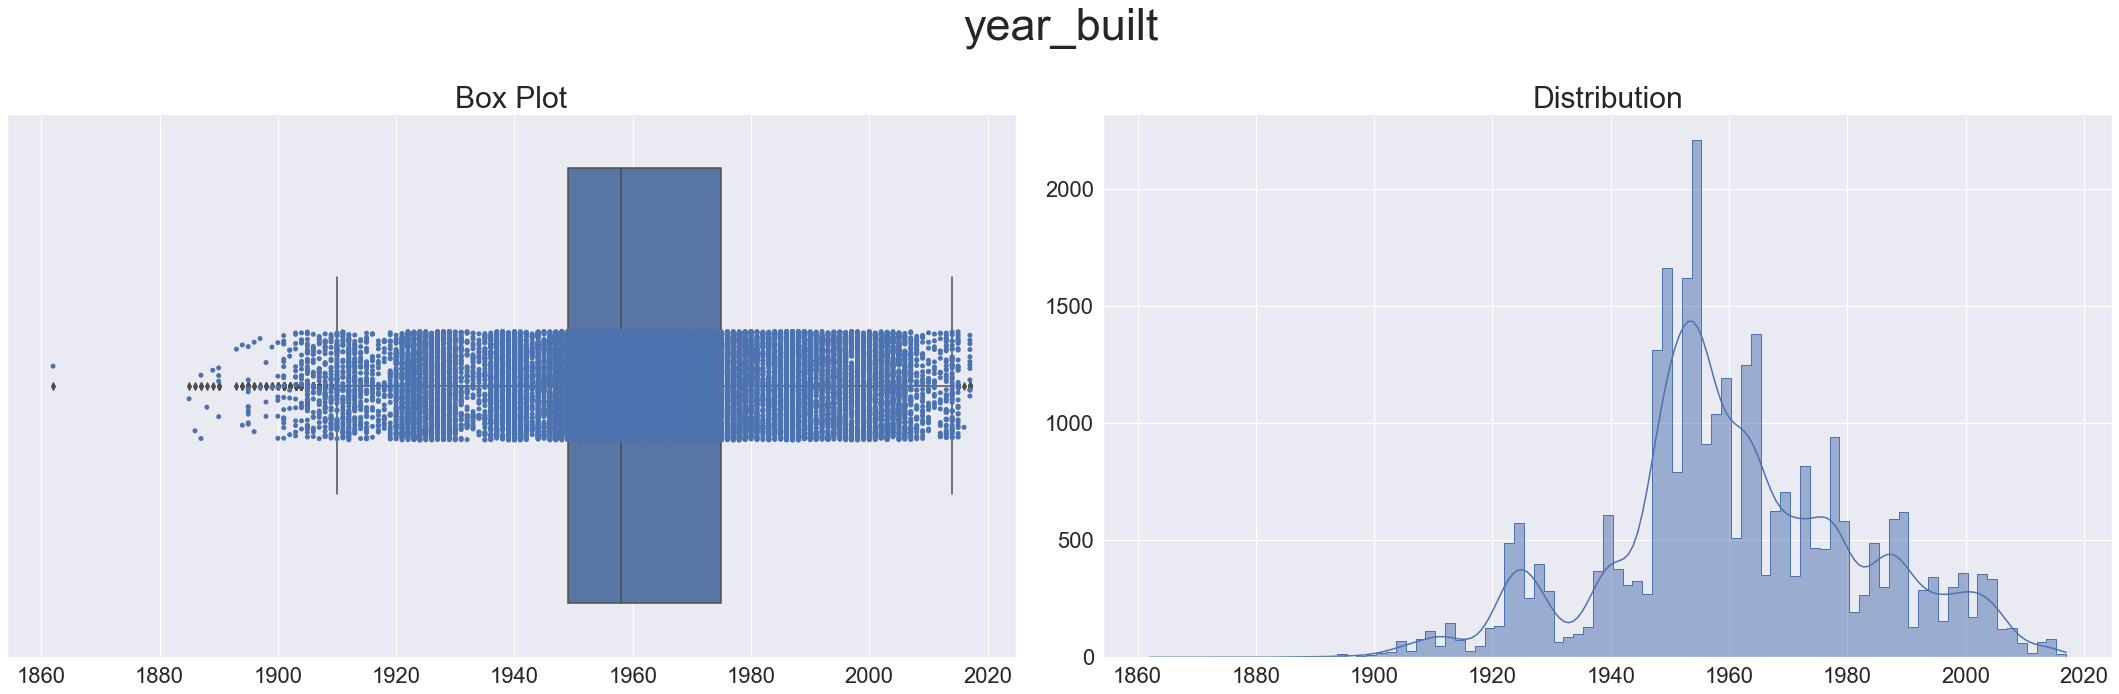

Summary Statistics for year_built
count    30163.000000
mean      1960.711103
std         21.437040
min       1862.000000
25%       1949.000000
50%       1958.000000
75%       1975.000000
max       2017.000000
Name: year_built, dtype: float64


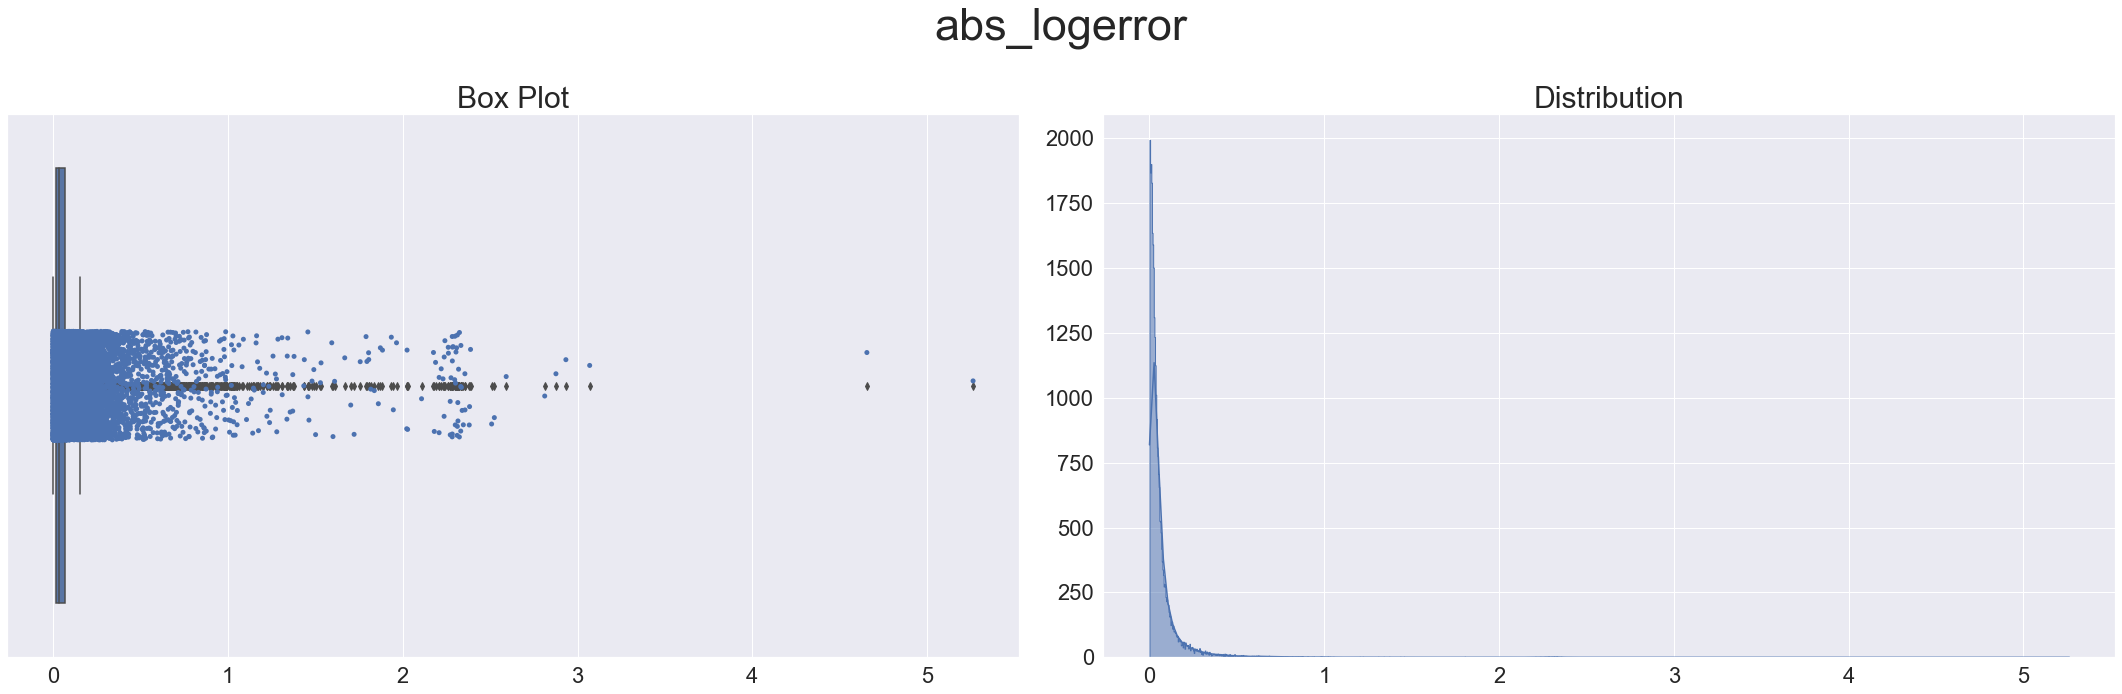

Summary Statistics for abs_logerror
count    30163.000000
mean         0.070875
std          0.159742
min          0.000003
25%          0.013957
50%          0.032267
75%          0.068646
max          5.262999
Name: abs_logerror, dtype: float64


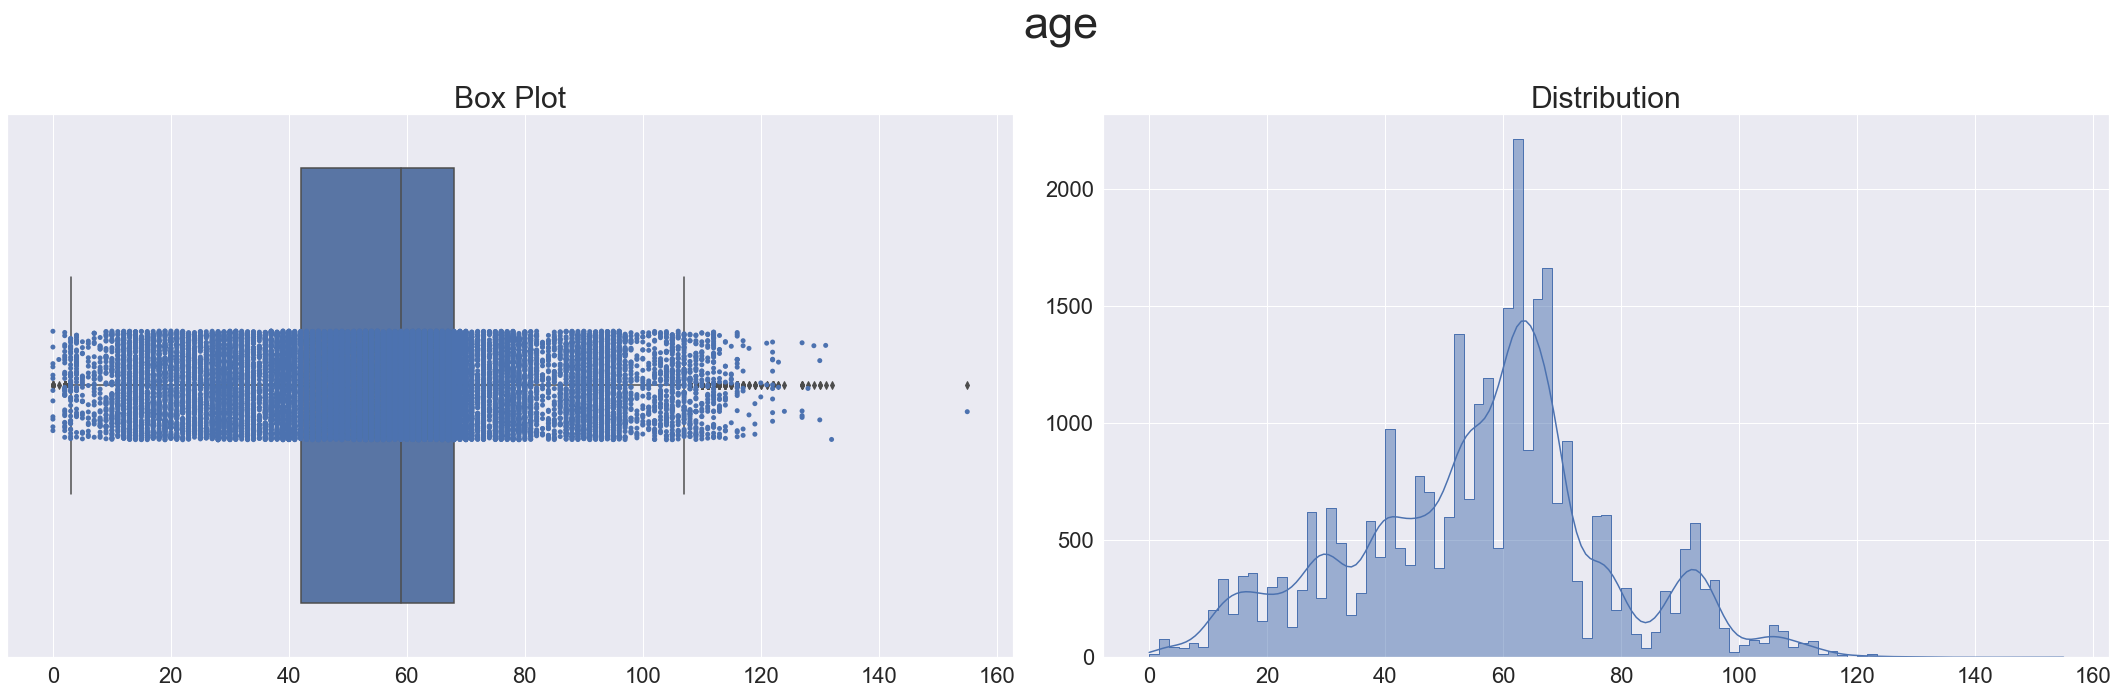

Summary Statistics for age
count    30163.000000
mean        56.288897
std         21.437040
min          0.000000
25%         42.000000
50%         59.000000
75%         68.000000
max        155.000000
Name: age, dtype: float64


In [5]:
# Explore some stuff
univariate_stuff = ['sqft','acres','tax_value','tax_amount','logerror', 'year_built','abs_logerror','age']

for i in univariate_stuff:
    e.explore_univariate(train, i)
    print(f'Summary Statistics for {i}\n{train[i].describe()}')

*Key take aways* 

- with the cuts log error is pretty normally distributed with some extreme outliers
- acres is right skewed perhaps lotsize has a factor in logerror
- created abs value for log error

<Figure size 2160x720 with 0 Axes>

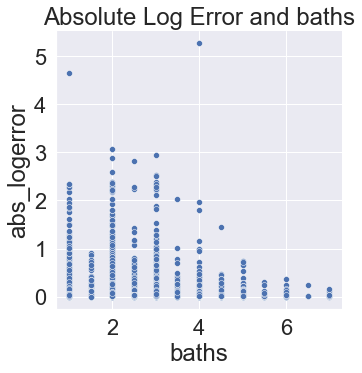

<Figure size 2160x720 with 0 Axes>

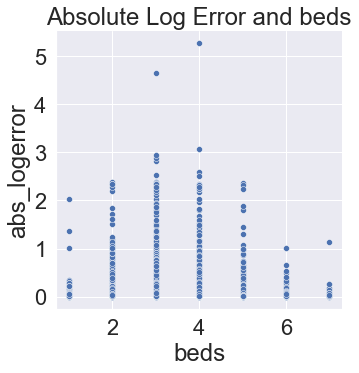

<Figure size 2160x720 with 0 Axes>

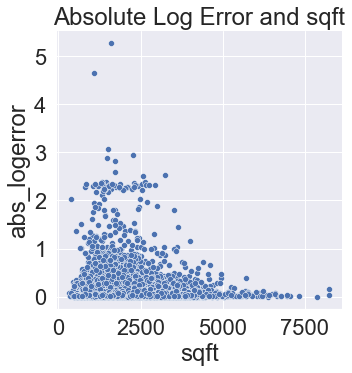

<Figure size 2160x720 with 0 Axes>

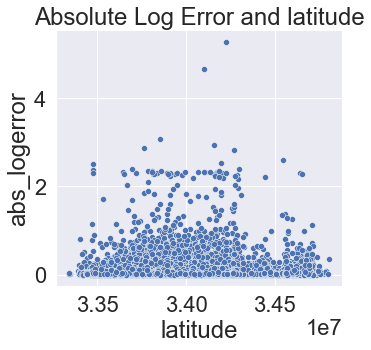

<Figure size 2160x720 with 0 Axes>

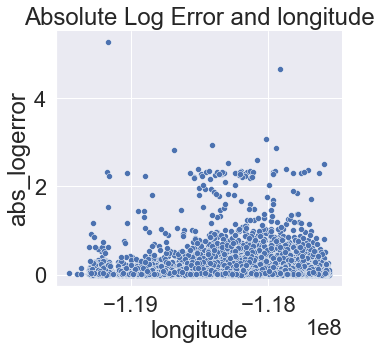

<Figure size 2160x720 with 0 Axes>

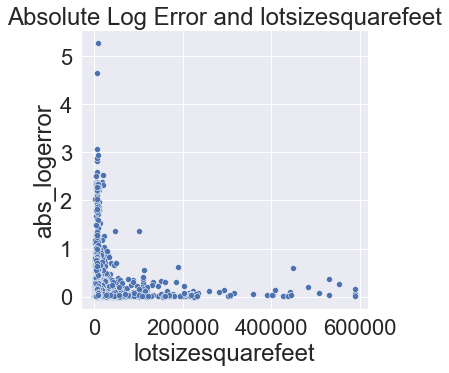

<Figure size 2160x720 with 0 Axes>

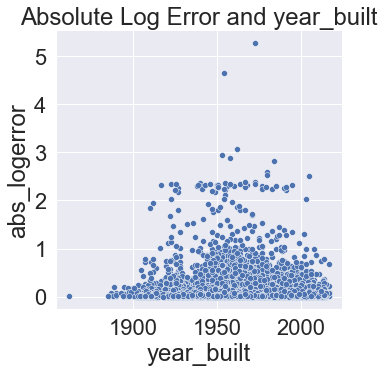

<Figure size 2160x720 with 0 Axes>

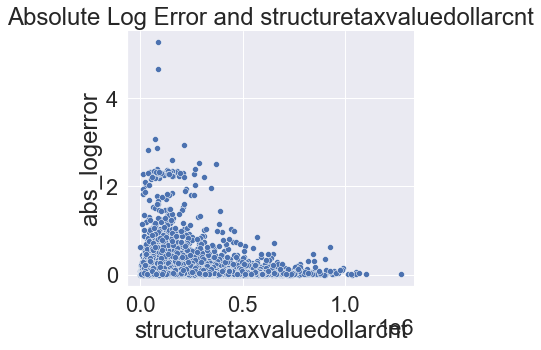

<Figure size 2160x720 with 0 Axes>

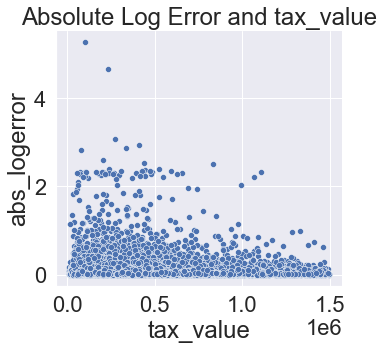

<Figure size 2160x720 with 0 Axes>

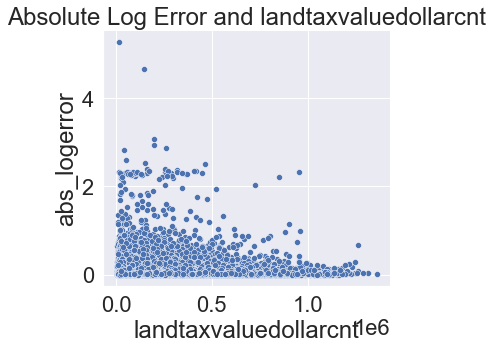

<Figure size 2160x720 with 0 Axes>

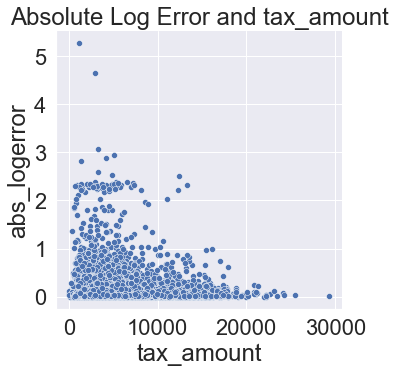

<Figure size 2160x720 with 0 Axes>

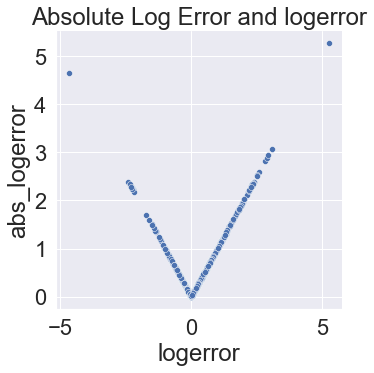

<Figure size 2160x720 with 0 Axes>

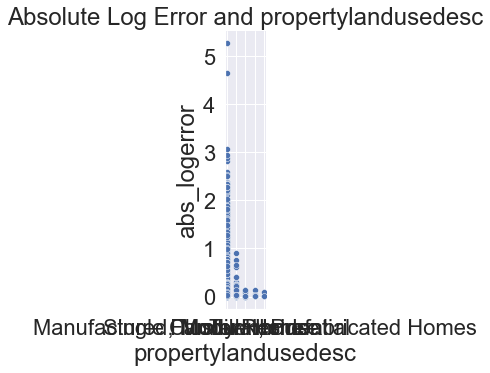

<Figure size 2160x720 with 0 Axes>

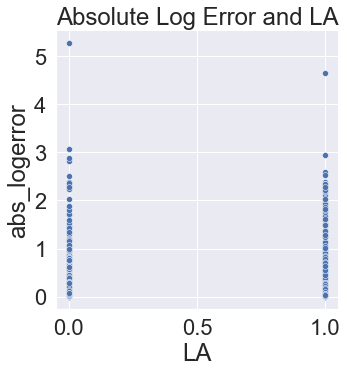

<Figure size 2160x720 with 0 Axes>

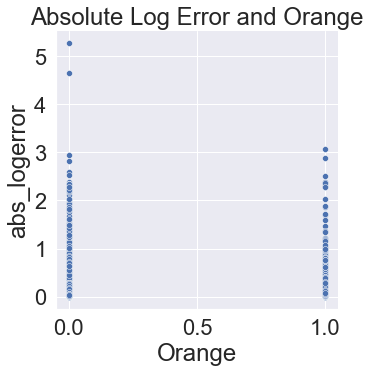

<Figure size 2160x720 with 0 Axes>

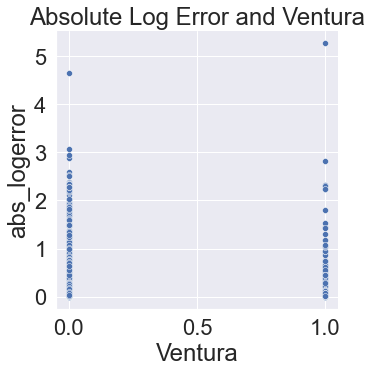

<Figure size 2160x720 with 0 Axes>

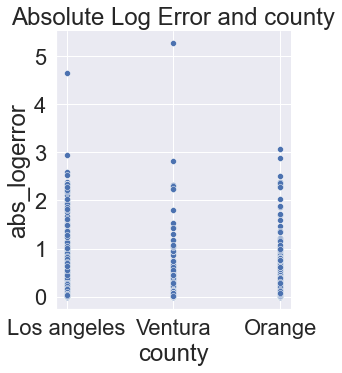

<Figure size 2160x720 with 0 Axes>

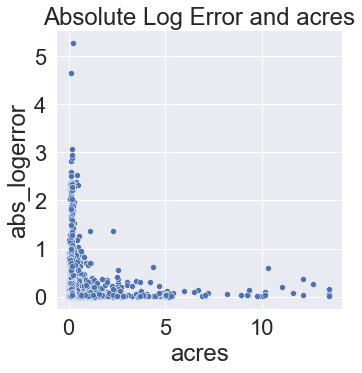

<Figure size 2160x720 with 0 Axes>

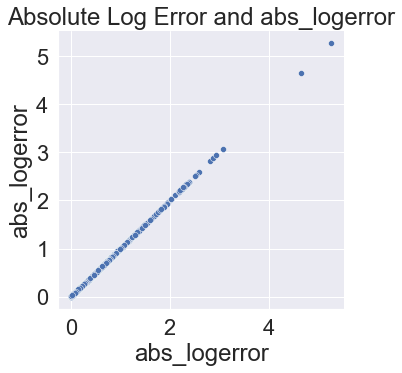

<Figure size 2160x720 with 0 Axes>

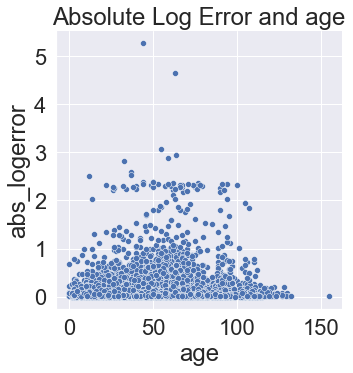

In [6]:
# Compare cols to our target
cols = e.cols()
for i in cols: 
    e.logerror_uni(train,i)

Takeaways:
* Age appears tobe a driver of log error
* As does Tax Value
* longitude and latitude appear to be as well i would like to combine these.
    
    

In [7]:
# Add scalled columns of numeric data using a minmax scaler
train, validate, test = e.add_scaled_columns(
    train,
    validate,
    test,
    scaler=sklearn.preprocessing.MinMaxScaler(),
    columns_to_scale=['sqft',
                      'beds',
                      'baths',
                      'year_built',
                      'latitude',
                      'longitude',
                      'acres',
                      'tax_value',
                      'age',
                     'structuretaxvaluedollarcnt'])

# Clustering
Create a clusters
* latitude and longitude
* Latitude and Tax Value
* Tax Value and Age


### Cluster 1 Lat/Long

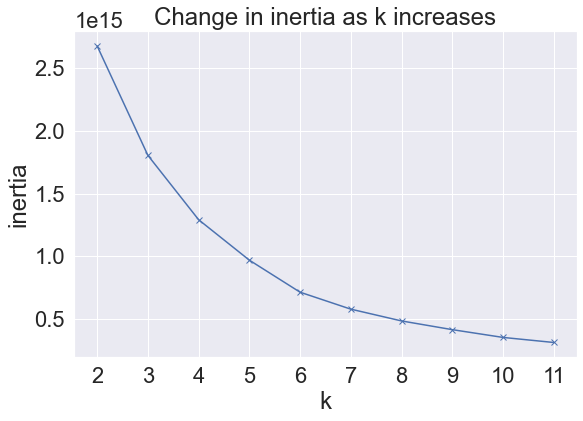

In [8]:
# Determine the best k by use of the elbow method
X = train[['longitude', 'latitude']]
e.inertia_graph(X)

In [9]:
# k=5 looks to be 45 degrees

# name the cluster column
cluster_name = 'lat_long_cluster'

# make five clusters
k = 5

# create a cluster column
X = train[['longitude_scaled', 'latitude_scaled']]
train, X, scaler, kmeans, centroids = e.create_cluster(train, X, k, cluster_name)


# create the same clusters for validate
X = validate[['longitude_scaled', 'latitude_scaled']]
validate, X, scaler, kmeans, centroids = e.create_cluster(validate, X, k, cluster_name)


# create the same clusters for test
X = test[['longitude_scaled', 'latitude_scaled']]
test, X, scaler, kmeans, centroids = e.create_cluster(test, X, k, cluster_name)

# create a scaled column for the cluster using min max scaling
train, validate, test = e.add_scaled_columns(
    train,
    validate,
    test,
    scaler=sklearn.preprocessing.MinMaxScaler(),
    columns_to_scale=['lat_long_cluster'])
train.shape, validate.shape, test.shape

((30163, 33), (12927, 33), (10773, 33))

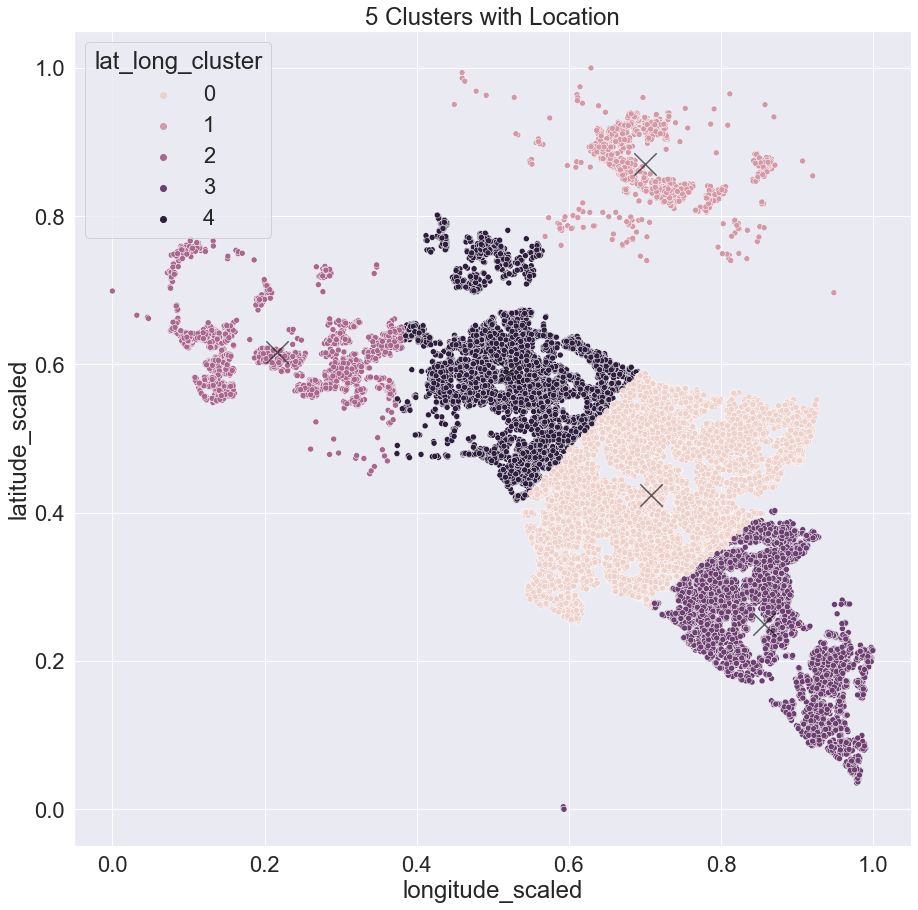

In [10]:
# Plot the latitude and longitude clusters
e.plot_clusters('longitude_scaled', 'latitude_scaled', 'lat_long_cluster', train, kmeans, scaler, centroids)
plt.title('5 Clusters with Location')
plt.show()

<AxesSubplot:>

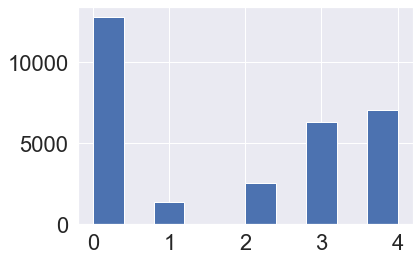

In [11]:
# Looking at the distros for the cluster
train.lat_long_cluster.hist()

In [12]:
# Summary Stats
train.groupby('lat_long_cluster').abs_logerror.describe()

count      mean       std       min       25%       50%  \
lat_long_cluster                                                              
0                 12781.0  0.070125  0.155950  0.000003  0.013652  0.031791   
1                  1395.0  0.074874  0.167095  0.000012  0.013749  0.032827   
2                  2579.0  0.071159  0.179615  0.000033  0.014774  0.032870   
3                  6328.0  0.069755  0.150373  0.000023  0.014118  0.031987   
4                  7080.0  0.072338  0.165386  0.000005  0.014120  0.033020   

                       75%       max  
lat_long_cluster                      
0                 0.067739  4.655420  
1                 0.068772  2.591723  
2                 0.069532  5.262999  
3                 0.069275  2.876386  
4                 0.069383  2.933328

The Kruskal-Wallis H-test tests the null hypothesis that the population median of all of the groups are equal and does not need the normalcy of a data set that an ANOVA test would require.

Kruskal-Wallis H-test:

$H_0$: there is no difference in log error between the population mean of the 5 clusters

$H_a$: there is a significant difference in log error between the population mean of the 5 clusters


In [13]:
stats.kruskal(    
    train.query('lat_long_cluster == 0').abs_logerror,
    train.query('lat_long_cluster == 1').abs_logerror,
    train.query('lat_long_cluster == 2').abs_logerror,
    train.query('lat_long_cluster == 3').abs_logerror,
    train.query('lat_long_cluster == 4').abs_logerror)

KruskalResult(statistic=3.1959090921327284, pvalue=0.5255919521271312)

We fail to reject the null hypothesis there is not significant data that supports our hypothesis

Lets approach this from a different way lets look at the stats for each cluster

In [14]:
train.groupby('lat_long_cluster').abs_logerror.describe()

count      mean       std       min       25%       50%  \
lat_long_cluster                                                              
0                 12781.0  0.070125  0.155950  0.000003  0.013652  0.031791   
1                  1395.0  0.074874  0.167095  0.000012  0.013749  0.032827   
2                  2579.0  0.071159  0.179615  0.000033  0.014774  0.032870   
3                  6328.0  0.069755  0.150373  0.000023  0.014118  0.031987   
4                  7080.0  0.072338  0.165386  0.000005  0.014120  0.033020   

                       75%       max  
lat_long_cluster                      
0                 0.067739  4.655420  
1                 0.068772  2.591723  
2                 0.069532  5.262999  
3                 0.069275  2.876386  
4                 0.069383  2.933328

lat_long_cluster
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
2    AxesSubplot(0.125,0.125;0.775x0.755)
3    AxesSubplot(0.125,0.125;0.775x0.755)
4    AxesSubplot(0.125,0.125;0.775x0.755)
Name: abs_logerror, dtype: object

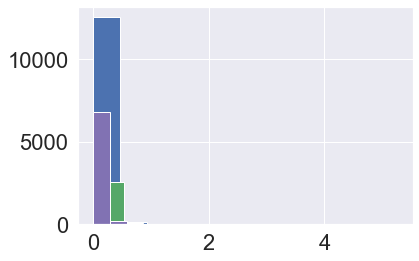

In [15]:
train.groupby('lat_long_cluster').abs_logerror.hist()

$H_0$: there is no difference in log error between the population mean of cluster 4 and the other clusters

$H_a$: there is a significant difference in log error between the population mean of cluster 4 and the other clusters

In [16]:
sample1 = train[train['lat_long_cluster']==4].abs_logerror
sample2 = train[train['lat_long_cluster']!= 4].abs_logerror
sample1.var(), sample2.var()

(0.027352501510154746, 0.02495479630269822)

In [17]:
stats.mannwhitneyu(sample1, sample2)

MannwhitneyuResult(statistic=81024650.5, pvalue=0.14113158214034738)

We fail to reject the null hypothesis this will not help us moving foward

### Cluster 2

Latitude and longitude isnt soley driving error lets add the tax value to the mix and see if it changes things, I will leave in latitude because beachfront propety might effect log error as prior exploration has told us

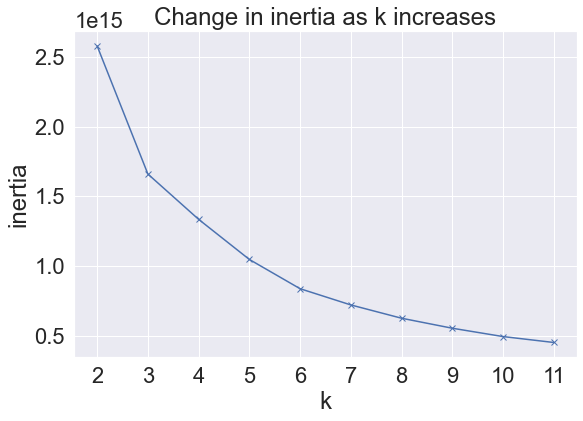

In [18]:
# Determine the best k by use of the elbow method
X = train[['latitude','tax_value']]
e.inertia_graph(X)

In [19]:
# k=4 is what the elbow method told me to choose

# name the cluster column
cluster_name = 'lat_val_cluster'
# make four clusters
k = 4


# create a cluster column
X = train[['latitude_scaled','tax_value_scaled']]
train, X, scaler, kmeans, centroids = e.create_cluster(train, X, k, cluster_name)


# create the same clusters for validate
X = validate[['latitude_scaled','tax_value_scaled']]
validate, X, scaler, kmeans, centroids = e.create_cluster(validate, X, k, cluster_name)


# create the same clusters for validate
X = test[['latitude_scaled','tax_value_scaled']]
test, X, scaler, kmeans, centroids = e.create_cluster(test, X, k, cluster_name)

train, validate, test = e.add_scaled_columns(
    train,
    validate,
    test,
    scaler=sklearn.preprocessing.MinMaxScaler(),
    columns_to_scale=['lat_val_cluster'])
train.shape, validate.shape, test.shape

((30163, 35), (12927, 35), (10773, 35))

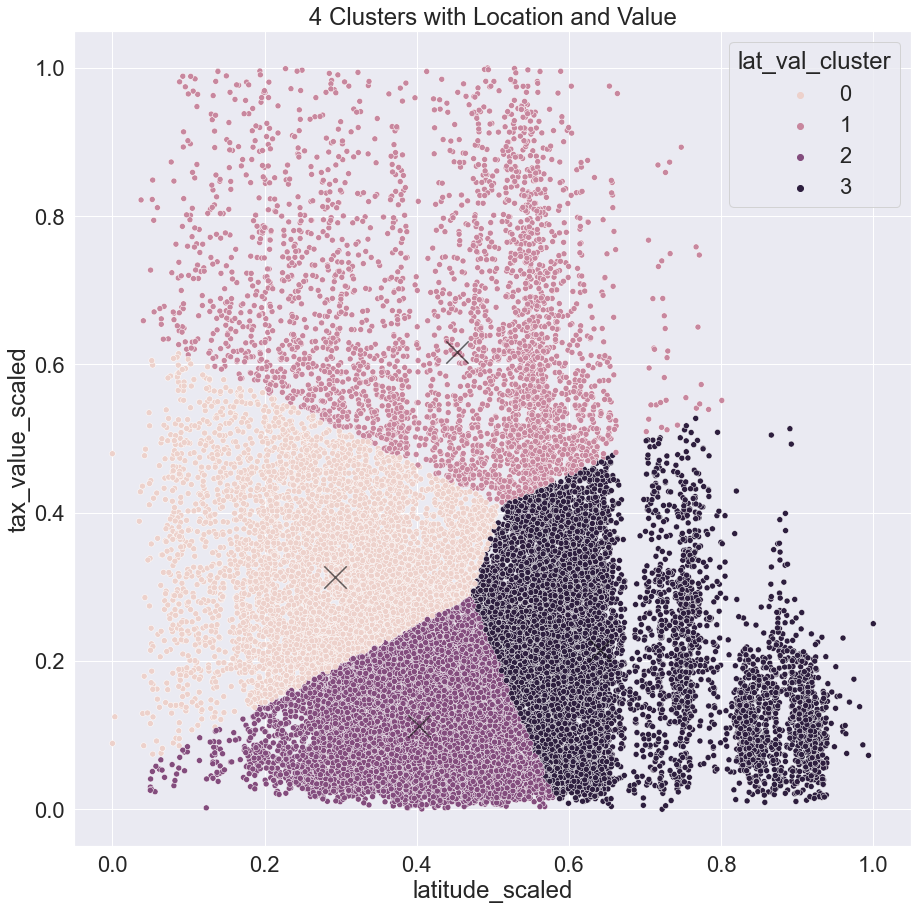

In [20]:
e.plot_clusters( 'latitude_scaled','tax_value_scaled', 'lat_val_cluster', train, kmeans, scaler, centroids)
plt.title('4 Clusters with Location and Value')
plt.show()

In [21]:
train.groupby('lat_val_cluster').abs_logerror.describe()

count      mean       std       min       25%       50%  \
lat_val_cluster                                                              
0                 6335.0  0.071312  0.154099  0.000007  0.014121  0.032626   
1                 3359.0  0.066288  0.129944  0.000020  0.013441  0.031927   
2                10418.0  0.070425  0.160256  0.000003  0.013961  0.031793   
3                10051.0  0.072599  0.171302  0.000005  0.014012  0.032717   

                      75%       max  
lat_val_cluster                      
0                0.070211  2.876386  
1                0.067553  2.315835  
2                0.068131  4.655420  
3                0.068751  5.262999

lat_val_cluster
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
2    AxesSubplot(0.125,0.125;0.775x0.755)
3    AxesSubplot(0.125,0.125;0.775x0.755)
Name: abs_logerror, dtype: object

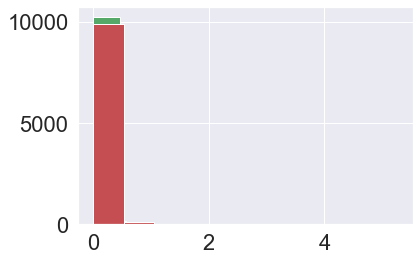

In [22]:
train.groupby('lat_val_cluster').abs_logerror.hist()

Levene's Test: test for equal variance

$H_0$: there is no difference in absolute log error variance between the samples

$H_a$: there is a difference in absolute log error variance between the samples

In [23]:
# Set Aplha
alpha=.05
## use a levene test to check variance
stats.levene(
    train.query('lat_val_cluster == 0').abs_logerror,
    train.query('lat_val_cluster == 1').abs_logerror,
    train.query('lat_val_cluster == 2').abs_logerror,
    train.query('lat_val_cluster == 3').abs_logerror
)

LeveneResult(statistic=1.2442348631495095, pvalue=0.2918315088065255)

Fail to reject the Null hypothesis this data is not normal 

The Kruskal-Wallis H-test tests the null hypothesis that the population median of all of the groups are equal and does not need the normalcy of a data set that an ANOVA test would require.

Kruskal-Wallis H-test:

$H_0$: there is no difference in log error between the population mean of the 6 clusters

$H_a$: there is a significant difference in tax value between the population mean of the 6 clusters

In [24]:
stats.kruskal(
    train.query('lat_val_cluster == 0').abs_logerror,
    train.query('lat_val_cluster == 1').abs_logerror,
    train.query('lat_val_cluster == 2').abs_logerror,
    train.query('lat_val_cluster == 3').abs_logerror,)

KruskalResult(statistic=2.404339914543401, pvalue=0.4928272602921845)

We fail to reject the null hypotheisis. 

In statistics, the Mann–Whitney U test is a nonparametric test of the null hypothesis that, for randomly selected values X and Y from two populations, the probability of X being greater than Y is equal to the probability of Y being greater than X.
Man-Witney U-test:

$H_0$: there is no difference in log error between the population mean of the cluster 0 and 1, and the rest

$H_a$: there is a significant difference in tax value between the population mean of the cluster 0 and 1, and the rest

In [25]:
sample1 = train[train['lat_val_cluster_scaled']>1].abs_logerror
sample2 = train[train['lat_val_cluster_scaled']<=1].abs_logerror


In [26]:
stats.mannwhitneyu(sample1, sample2)

MannwhitneyuResult(statistic=0.0, pvalue=0.0)

We Reject the null hypothesis, it appears there is a significant difference between the clusters.

### Cluster 3

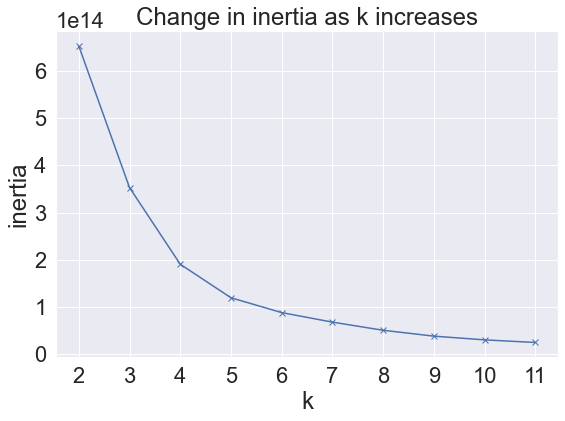

In [27]:
# Determine the best k by use of the elbow method
X = train[['latitude', 'age']]
e.inertia_graph(X)

In [28]:
# k=4 is what the elbow method told me to choose

# name the cluster column
cluster_name = 'val_age_cluster'
# make four clusters
k = 4


# create a cluster column
X = train[['tax_value_scaled','age_scaled']]
train, X, scaler, kmeans, centroids = e.create_cluster(train, X, k, cluster_name)


# create the same clusters for validate
X = validate[['tax_value_scaled','age_scaled']]
validate, X, scaler, kmeans, centroids = e.create_cluster(validate, X, k, cluster_name)


# create the same clusters for validate
X = test[['tax_value_scaled','age_scaled']]
test, X, scaler, kmeans, centroids = e.create_cluster(test, X, k, cluster_name)

train, validate, test = e.add_scaled_columns(
    train,
    validate,
    test,
    scaler=sklearn.preprocessing.MinMaxScaler(),
    columns_to_scale=['val_age_cluster'])
train.shape, validate.shape, test.shape

((30163, 37), (12927, 37), (10773, 37))

In [29]:
train.groupby('val_age_cluster').abs_logerror.describe()

count      mean       std       min       25%       50%  \
val_age_cluster                                                              
0                 6772.0  0.071011  0.158007  0.000011  0.013671  0.031898   
1                12797.0  0.071941  0.167855  0.000003  0.014020  0.032324   
2                 7257.0  0.070690  0.158193  0.000005  0.014127  0.032157   
3                 3337.0  0.066908  0.132346  0.000020  0.013856  0.032844   

                      75%       max  
val_age_cluster                      
0                0.068661  2.812168  
1                0.069018  5.262999  
2                0.067858  2.933328  
3                0.069158  2.508444

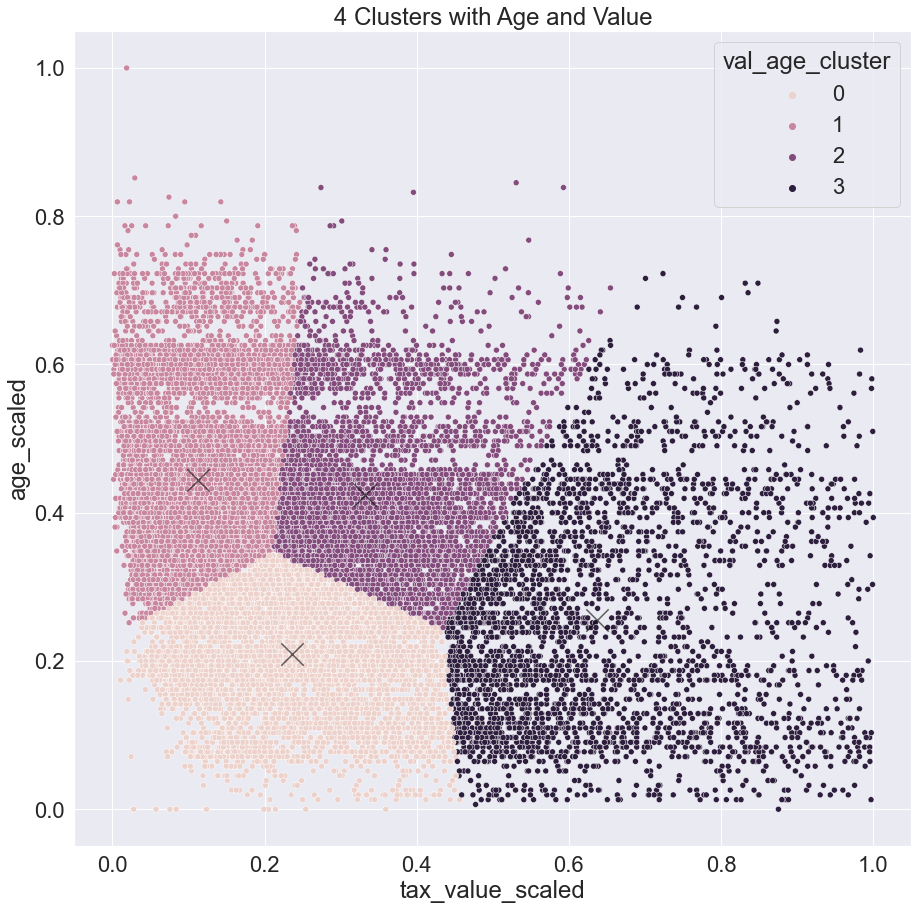

In [30]:
e.plot_clusters( 'tax_value_scaled','age_scaled', 'val_age_cluster', train, kmeans, scaler, centroids)
plt.title('4 Clusters with Age and Value')
plt.show()

In [31]:
train.groupby('val_age_cluster').abs_logerror.describe()

count      mean       std       min       25%       50%  \
val_age_cluster                                                              
0                 6772.0  0.071011  0.158007  0.000011  0.013671  0.031898   
1                12797.0  0.071941  0.167855  0.000003  0.014020  0.032324   
2                 7257.0  0.070690  0.158193  0.000005  0.014127  0.032157   
3                 3337.0  0.066908  0.132346  0.000020  0.013856  0.032844   

                      75%       max  
val_age_cluster                      
0                0.068661  2.812168  
1                0.069018  5.262999  
2                0.067858  2.933328  
3                0.069158  2.508444

The Kruskal-Wallis H-test tests the null hypothesis that the population median of all of the groups are equal and does not need the normalcy of a data set that an ANOVA test would require.

Kruskal-Wallis H-test:

$H_0$: there is no difference in log error between the population mean of the 4 clusters

$H_a$: there is a significant difference in log error between the population mean of the 4 clusters

In [32]:
stats.kruskal(
    train.query('val_age_cluster == 0').abs_logerror,
    train.query('val_age_cluster == 1').abs_logerror,
    train.query('val_age_cluster == 2').abs_logerror,
    train.query('val_age_cluster == 3').abs_logerror)

KruskalResult(statistic=0.6299362198336483, pvalue=0.8895462493086922)

We fail to reject the hypothises null

In statistics, the Mann–Whitney U test is a nonparametric test of the null hypothesis that, for randomly selected values X and Y from two populations, the probability of X being greater than Y is equal to the probability of Y being greater than X.
Man-Witney U-test:

$H_0$: there is no difference in  the population mean of the log error of cluster 3 and the population mean of the log error  rest

$H_a$: there is a significant difference in  the population mean of the log error of cluster 3 and the population mean of the log error  rest

In [33]:
sample1 = train[train['val_age_cluster_scaled']!=3].abs_logerror
sample2 = train[train['val_age_cluster_scaled']==3].abs_logerror
stats.mannwhitneyu(sample1, sample2)

MannwhitneyuResult(statistic=0.0, pvalue=0.0)

We reject the null hypothesis

# Lets choose some features

In [34]:
# Im creating a clone train to act as scaled data to throw into regression models
train2=train.copy()
train2=train2.drop(columns=['parcelid',
                     'baths',
                     'beds',
                     'sqft',
                     'latitude',
                     'longitude',
                     'lotsizesquarefeet',
                     'year_built',
                     'structuretaxvaluedollarcnt',
                     'tax_value',
                     'landtaxvaluedollarcnt',
                     'tax_amount',
                     'logerror',
                     'propertylandusedesc',
                     'county',
                     'acres',
                     'age',
                     'lat_long_cluster',
                     'lat_val_cluster',
                     'val_age_cluster'])
train.shape,train2.shape

((30163, 37), (30163, 17))

In [35]:
# Same is true for validate
validate2=validate.copy()
validate2=validate2.drop(columns=['parcelid',
                     'baths',
                     'beds',
                     'sqft',
                     'latitude',
                     'longitude',
                     'lotsizesquarefeet',
                     'year_built',
                     'structuretaxvaluedollarcnt',
                     'tax_value',
                     'landtaxvaluedollarcnt',
                     'tax_amount',
                     'logerror',
                     'propertylandusedesc',
                     'county',
                     'acres',
                     'age',
                     'lat_long_cluster',
                     'lat_val_cluster',
                     'val_age_cluster'])
validate.shape,validate2.shape

((12927, 37), (12927, 17))

In [36]:
# And test
test2=test.copy()
test2=test2.drop(columns=['parcelid',
                     'baths',
                     'beds',
                     'sqft',
                     'latitude',
                     'longitude',
                     'lotsizesquarefeet',
                     'year_built',
                     'structuretaxvaluedollarcnt',
                     'tax_value',
                     'landtaxvaluedollarcnt',
                     'tax_amount',
                     'logerror',
                     'propertylandusedesc',
                     'county',
                     'acres',
                     'age',
                     'lat_long_cluster',
                     'lat_val_cluster',
                     'val_age_cluster'])
test.shape,test2.shape

((10773, 37), (10773, 17))

In [37]:
# Create my x_train and friends focusing on ABS log error
X_train, y_train, X_validate, y_validate, X_test, y_test = w.xysplit(train2,validate2,test2,'abs_logerror')

In [38]:
# Im going to make choose my features for modeling using a rfe 
lm = LinearRegression()

# create the rfe object. 
rfe = RFE(lm, 12)

# fit the data using RFE
rfe.fit(X_train,y_train)  

# get the mask of the columns selected
feature_mask = rfe.support_

# get list of the column names. 
rfe_feature = X_train.iloc[:,feature_mask].columns.tolist()
rfe_feature

['LA',
 'Orange',
 'Ventura',
 'sqft_scaled',
 'beds_scaled',
 'baths_scaled',
 'year_built_scaled',
 'latitude_scaled',
 'acres_scaled',
 'tax_value_scaled',
 'age_scaled',
 'structuretaxvaluedollarcnt_scaled']

In [39]:
X_train = X_train[rfe_feature]
X_validate = X_validate[rfe_feature]
X_test = X_test[rfe_feature]
X_train.shape, X_validate.shape, X_test.shape

((30163, 12), (12927, 12), (10773, 12))

# Establishing a Baseline

In [40]:
# create dataframes out of y series
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)


# 1. Predict log error_baseline mean
baseline_mean = y_train['abs_logerror'].mean()
y_train['baseline_mean'] = baseline_mean
y_validate['baseline_mean'] = baseline_mean


# 3. RMSE of log error mean
rmse_train = mean_squared_error(y_train.abs_logerror, y_train.baseline_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.abs_logerror, y_validate.baseline_mean)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  0.16 
Validate/Out-of-Sample:  0.15


Looks like i need to beat a score of .15

In [41]:
# create the model object
lm = LinearRegression(normalize=True)

e.rmse(lm, X_train, X_validate, y_train, y_validate, 'abs_logerror', 'model1_lr')

RMSE for model1_lr using LinearRegression(normalize=True) 
Training/In-Sample:  0.1597255269835122 
Validation/Out-of-Sample:  0.14950052346348475



(0.1597255269835122, 0.14950052346348475)

Not to good,  narrowly beats baseline but the variation between train and validate is a little scary for test

In [42]:
# create the model object
lars = LassoLars(alpha=1.0)

e.rmse(lars, X_train, X_validate, y_train, y_validate, 'abs_logerror', 'model2_lars')

RMSE for model2_lars using LassoLars() 
Training/In-Sample:  0.159738909257793 
Validation/Out-of-Sample:  0.1495307532002899



(0.159738909257793, 0.1495307532002899)

This is starting to look like the best im going to get

In [43]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)

e.rmse(glm, X_train, X_validate, y_train, y_validate, 'abs_logerror', 'model3_Tweedieregressor')

RMSE for model3_Tweedieregressor using TweedieRegressor(alpha=0, power=1) 
Training/In-Sample:  0.15971045098569212 
Validation/Out-of-Sample:  0.14950425872279216



(0.15971045098569212, 0.14950425872279216)

Even more minimally better, so far our best performing model is still out first model

In [44]:
pr = PolynomialFeatures(degree=2)

lm2 = LinearRegression(normalize=True)

# fit and transform X_train_scaled
X_train2 = pr.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate2 = pr.transform(X_validate)

e.rmse(lm2, X_train2, X_validate2, y_train, y_validate, 'abs_logerror', 'model4_pr')

RMSE for model4_pr using LinearRegression(normalize=True) 
Training/In-Sample:  0.15953650062795274 
Validation/Out-of-Sample:  0.14970435760226677



(0.15953650062795274, 0.14970435760226677)

less good looks like model 1 is going to be the ticket

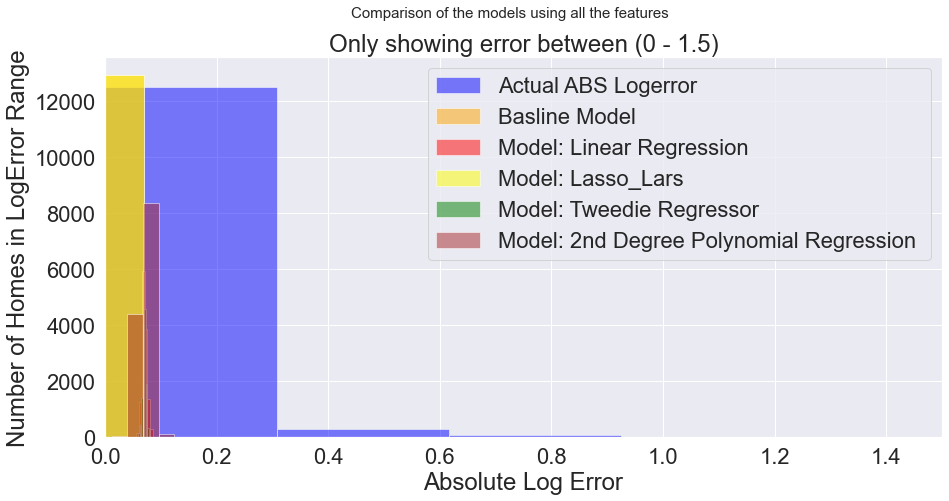

In [45]:
plt.figure(figsize=(15,7))
plt.hist(y_validate['abs_logerror'], color='blue', alpha=.5, label="Actual ABS Logerror", )
plt.hist(y_validate['baseline_mean'], color='orange', alpha=.5, label="Basline Model")
plt.hist(y_validate['model1_lr'], color='red', alpha=.5, label="Model: Linear Regression")
plt.hist(y_validate['model2_lars'], color='yellow', alpha=.5, label="Model: Lasso_Lars")
plt.hist(y_validate['model3_Tweedieregressor'], color='green', alpha=.5, label="Model: Tweedie Regressor")
plt.hist(y_validate['model4_pr'], color='brown', alpha=.5, label="Model: 2nd Degree Polynomial Regression ")
plt.suptitle("Comparison of the models using all the features", fontsize = 15)
plt.title("Only showing error between (0 - 1.5)")
plt.xlabel("Absolute Log Error")
plt.ylabel("Number of Homes in LogError Range")
plt.xlim(left = 0, right = 1.5)
plt.legend()
plt.show()

In [46]:
# create the model object
lm = LinearRegression(normalize=True)
e.rmse(lm, X_train, X_validate, y_train, y_validate, 'abs_logerror', 'model1_lr')
y_test['model1_lr'] = lm.predict(X_test)

RMSE for model1_lr using LinearRegression(normalize=True) 
Training/In-Sample:  0.1597255269835122 
Validation/Out-of-Sample:  0.14950052346348475



In [47]:
# evaluate: rmse for train
rmse_train = mean_squared_error(y_train['abs_logerror'], y_train['model1_lr'])**(1/2)

# evaluate: rmse for validate
rmse_validate = mean_squared_error(y_validate['abs_logerror'], y_validate['model1_lr'])**(1/2)

# evaluate RMSE for test
rmse_test = mean_squared_error(y_test['abs_logerror'], y_test['model1_lr'])**(1/2)

print("RMSE for OLS Model\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate,
     "\nTest/Out-of-Sample: ", rmse_test)

RMSE for OLS Model
Training/In-Sample:  0.1597255269835122 
Validation/Out-of-Sample:  0.14950052346348475 
Test/Out-of-Sample:  0.16146151424220911


**Our model does not beat baseline on unseen data**


## Conclusion:

Our model was not able to beat the baseline rmse of .15 

It scored an rmse of .161

Our clusters where not benefiecal to the process with rfe putting almost every created cluster at the bottom

The following where the drivers rfe picked
- 'LA',
- 'Orange',
- 'Ventura',
- 'sqft_scaled',
- 'beds_scaled',
- 'baths_scaled',
- 'year_built_scaled',
- 'latitude_scaled',
- 'longitude_scaled',
- 'acres_scaled',
- 'age_scaled',
- 'structuretaxvaluedollarcnt_scaled'

Moving foward my recommendation is to continue using the current models until such a time I can create substaintial clusters. 

# Given more time
- I'd spend more time engineering effective clusters, maybe throwing more than 2 variables into a cluster at a time
- I'd also like to break the models down to a per county bases and try to establish effective neighborhood clusters